# 2D Post-stack inversion with box constraint

This notebook is intended to test different versions of proximal algorithms with multiple regularization terms. More specifically, we will consider the following problems as our test bed:

$$
argmin_\mathbf{x} \|\mathbf{Gx} - \mathbf{d}\|_2^2 + \|\nabla^2 \mathbf{x}\|_2^2 + i_{Box(0, 1)}
$$

and 

$$
argmin_\mathbf{x} \|\mathbf{Gx} - \mathbf{d}\|_2^2 + \|\nabla \mathbf{x}\|_{2,1} + i_{Box(0, 1)}
$$

where the first problem can be solved using the ProximalGradient algorithm whilst the second approach requires using ADMM/PD leveraging the concept of prior stacking, or a generalized version of the ADMM.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.utils.metrics import snr
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.basicoperators import VStack as VStacklop

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

## Model creation

In [2]:
nt0, nx = 301, 251
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

ai = 1600 * np.ones(nt0)
ai[51:71] = 1700
ai[71:121] = 2200
ai[121:151] = 1600
ai[151:251] = 2000
ai[251:] = 2200
ai1 = np.outer(ai, np.ones(nx))
ai2d = np.roll(ai1, 32, axis=0)
ai2d[:32] = 1600

# fault
tf = 0.3
kf = 5e-4
fault = x * kf + tf
mask = np.zeros_like(ai1, dtype=int)
for ix in range(nx):
    ai2d[int(fault[ix]/dt0):, ix] = ai1[int(fault[ix]/dt0):, ix]
ai2d *= 2000

# logarithmic model
#m = np.log(ai2d)

# model between 0 and 1
m = (ai2d - ai2d.min()) / (ai2d.max() - ai2d.min())
m.min(), m.max()

(np.float64(0.0), np.float64(1.0))

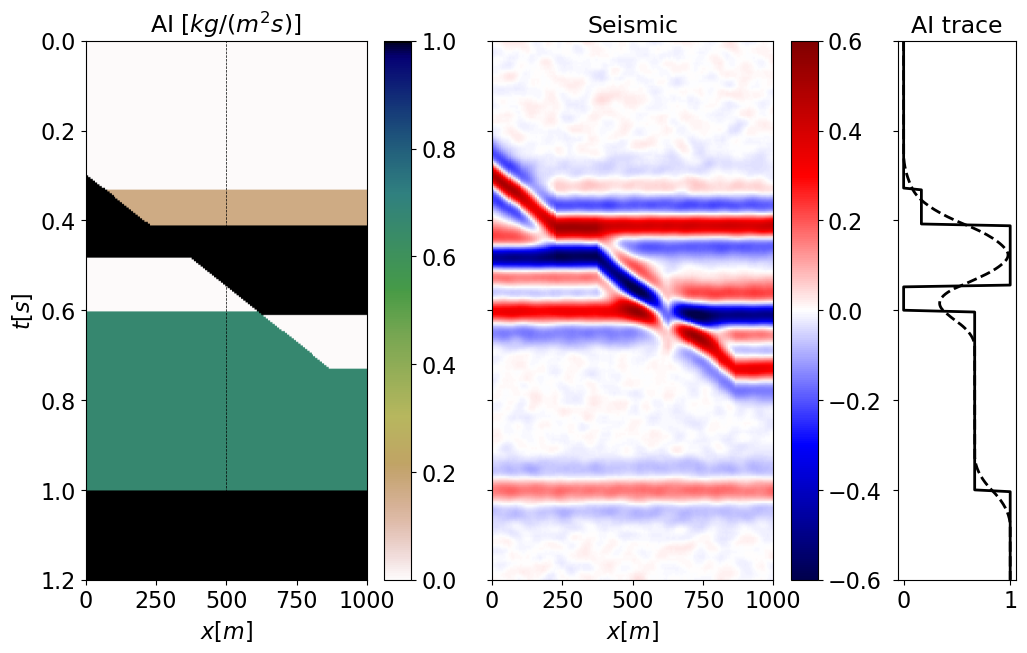

In [3]:
# smooth model
nsmooth = 20
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()
d = d.reshape(nt0, nx)

# colored noise
sigman = 1e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust')
dn = d + n

fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(m, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(dn, cmap='seismic', vmin=-0.6, vmax=0.6, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Seismic', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(m[:, nx//2], t0, 'k', lw=2)
axs[2].plot(mback[:, nx//2], t0, '--k', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

In [4]:
#Normalize operator and data term by eigvalues
eigmax = (Lop.H @ Lop).eigs(1)
Lop = np.sqrt(1/eigmax[0].real) * Lop
# Lop.dimsd = (Lop.shape[1], )
dn = np.sqrt(1/eigmax[0].real) * dn

## Benchmark with Laplacian (without Box)

In [5]:
D2op = Laplacian(m.shape, dtype='float64', weights=(1, 1))

mreg = regularized_inversion(Lop, dn.ravel(), Regs=[D2op],
                             epsRs=[3., ],x0=(mback.ravel()), show=True,
                             **dict(iter_lim=201, damp=1e-1))[0].reshape(nt0, nx) 

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 75551 rows and 75551 cols
Regs=[<75551x75551 Laplacian with dtype=float64>]
epsRs=[3.0]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 151102 rows and 75551 columns
damp = 1.00000000000000e-01   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      201
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.071e+01  2.071e+01    1.0e+00  1.8e-01
     1  1.67385e-05   1.967e+01  1.967e+01    7.8e-01  8.0e-02   1.2e+01  1.0e+00
     2  1.92167e-04   1.909e+01  1.909e+01    7.6e-01  2.8e-01   1.3e+01  3.5e+00
     3  5.52836e-04   1.796e+01  1.796e+01    7.2e-01  2.1e-01   2.2e+01  1.0e+01
     4  1.11411e-03   1.624e+01  1.624e+01    6.5e-01  2.6e-01   2.7e+01  1.8e+01
     5  2.08473e

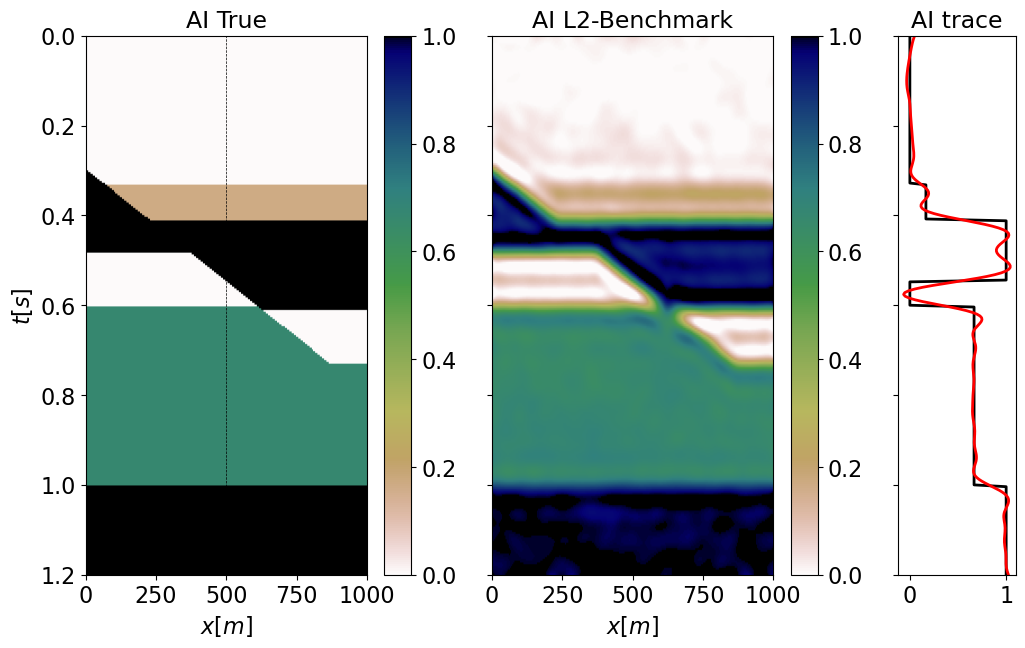

In [6]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(m, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(mreg, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI L2-Benchmark', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(m[:, nx//2], t0, 'k', lw=2)
axs[2].plot(mreg[:, nx//2], t0, 'r', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

## Proximal gradient (with Box)

In [7]:
eps = 3.
D2op = Laplacian(m.shape, dtype='float64', weights=(1, 1))
Op = VStacklop([Lop, np.sqrt(eps) * D2op])
Op.forceflat = True
data = np.hstack([dn.ravel(), np.zeros(D2op.shape[1])])
l2 = L2(Op=Op, b=data, x0=mback.ravel(), niter=10, warm=True)

box = Box(m.min(), m.max())

mpg = AcceleratedProximalGradient(l2, box, mback.ravel(), niter=200, show=True)
mpg = mpg.reshape(nt0, nx)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
tau = None	backtrack = False	beta = 5.000000e-01
epsg = 1.0	niter = 200	tol = None
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   3.51263e-05   1.907e+02   0.000e+00   1.907e+02   1.562e-02
     2   7.22251e-05   1.860e+02   0.000e+00   1.860e+02   1.562e-02
     3   1.20593e-04   1.807e+02   0.000e+00   1.807e+02   1.562e-02
     4   1.80415e-04   1.746e+02   0.000e+00   1.746e+02   1.562e-02
     5   2.52000e-04   1.679e+02   0.000e+00   1.679e+02   1.562e-02
     6   3.34848e-04   1.612e+02   0.000e+00   1.612e+02   1.562e-02
     7   3.97400e-04   1.552e+02   0.000e+00   1.552e+02   3.906e-03
     8   4.49787e-04   1.505e+02   0.000e+00   1.505e+02   3.906e-03
     9   4.97092e-04   1.467e+02   0.000e+00 

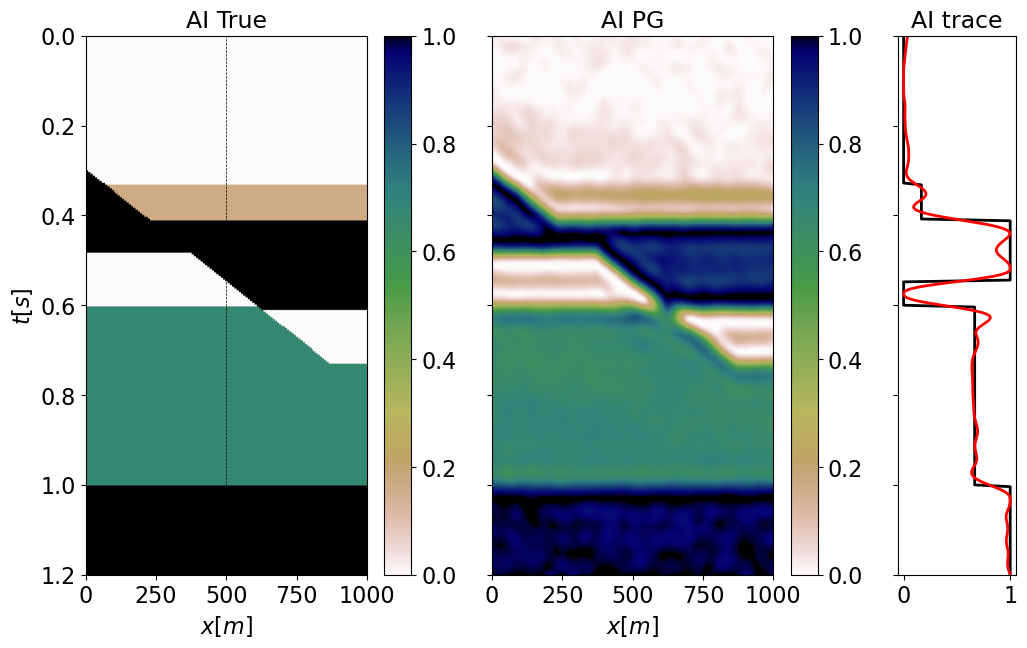

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(m, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(mpg, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI PG', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(m[:, nx//2], t0, 'k', lw=2)
axs[2].plot(mpg[:, nx//2], t0, 'r', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

## Benchmark with TV (without Box)

In [9]:
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99 / L

madmm = ADMML2(l1, Lop, dn.ravel(), Dop, x0=mback.ravel(), tau=tau, 
               niter=100, show=True, **dict(iter_lim=20))[0]
madmm = madmm.reshape(nt0, nx)

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
tau = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.97087e-02   5.992e+01   7.614e+00   6.753e+01
     2  -3.35523e-05   2.148e+01   9.033e+00   3.051e+01
     3  -6.25006e-03   1.089e+01   9.786e+00   2.067e+01
     4  -1.47547e-02   6.850e+00   1.010e+01   1.695e+01
     5  -9.52303e-03   4.957e+00   1.020e+01   1.516e+01
     6  -1.87156e-02   3.967e+00   1.023e+01   1.420e+01
     7   3.04236e-03   3.413e+00   1.021e+01   1.362e+01
     8  -7.85099e-03   3.047e+00   1.016e+01   1.320e+01
     9   9.93754e-03   2.767e+00   1.011e+01   1.287e+01
    10   3.34793e-03   2.561e+00   1.005e+01   1.261e+01
    11   1.44193e-02   2.396e+00   9.998e+00   1.239e+01
    21   2.35402e-02   1.726e+00   9.553e+00   1.128e+01
    31   2.72348e-02   1.520e+00   9.280e+00   1.080e+01
    41   2.92741e-02   1.418e+00   9.085e+00  

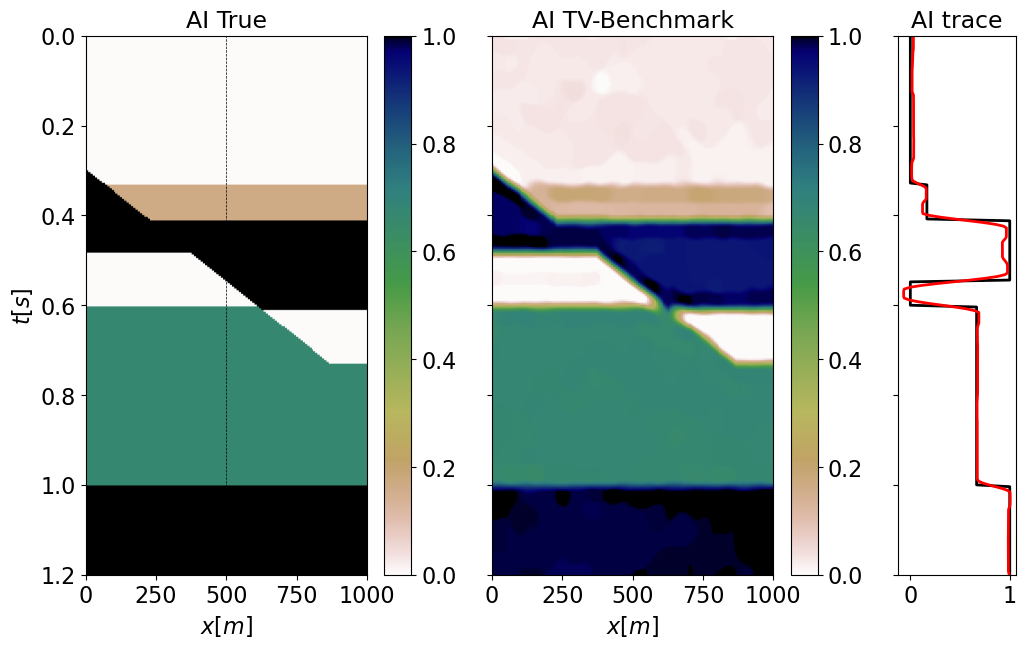

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(m, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(madmm, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI TV-Benchmark', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(m[:, nx//2], t0, 'k', lw=2)
axs[2].plot(madmm[:, nx//2], t0, 'r', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

## ADMML2 with Prior Stacking

In [11]:
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
box = Box(m.min(), m.max())
g = VStack([l1, box], [2 * nt0 * nx, nt0 * nx])

Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
Iop = Identity(nt0 * nx)
Kop = VStacklop([Dop, Iop])

L = 9. # np.real((Kop.H*Kop).eigs(neigs=1, which='LM')[0])
tau = 0.99 / L

madmm1, zadmm1 = ADMML2(g, Lop, dn.ravel(), Kop, x0=mback.ravel(), tau=tau, 
                        niter=100, gfirst=True, show=True, **dict(iter_lim=20))
madmm1 = madmm1.reshape(nt0, nx)

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
tau = 1.100000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   2.68457e-04   1.681e+02   6.550e+00   1.747e+02
     2   5.30774e-04   1.459e+02   6.562e+00   1.525e+02
     3   8.01666e-04   1.270e+02   6.564e+00   1.336e+02
     4   1.05659e-03   1.109e+02   6.559e+00   1.174e+02
     5   1.24512e-03   9.706e+01   6.574e+00   1.036e+02
     6   1.33348e-03   8.523e+01   6.597e+00   9.182e+01
     7   1.32817e-03   7.509e+01   6.642e+00   8.173e+01
     8   1.26940e-03   6.641e+01   6.722e+00   7.313e+01
     9   1.21411e-03   5.896e+01   6.825e+00   6.579e+01
    10   1.20817e-03   5.257e+01   6.951e+00   5.952e+01
    11   1.27004e-03   4.705e+01   7.097e+00   5.415e+01
    21   2.61686e-03   1.925e+01   8.335e+00   2.759e+01
    31   3.40789e-03   1.077e+01   8.920e+00   1.969e+01
    41   4.27501e-03   7.300e+00   9.174

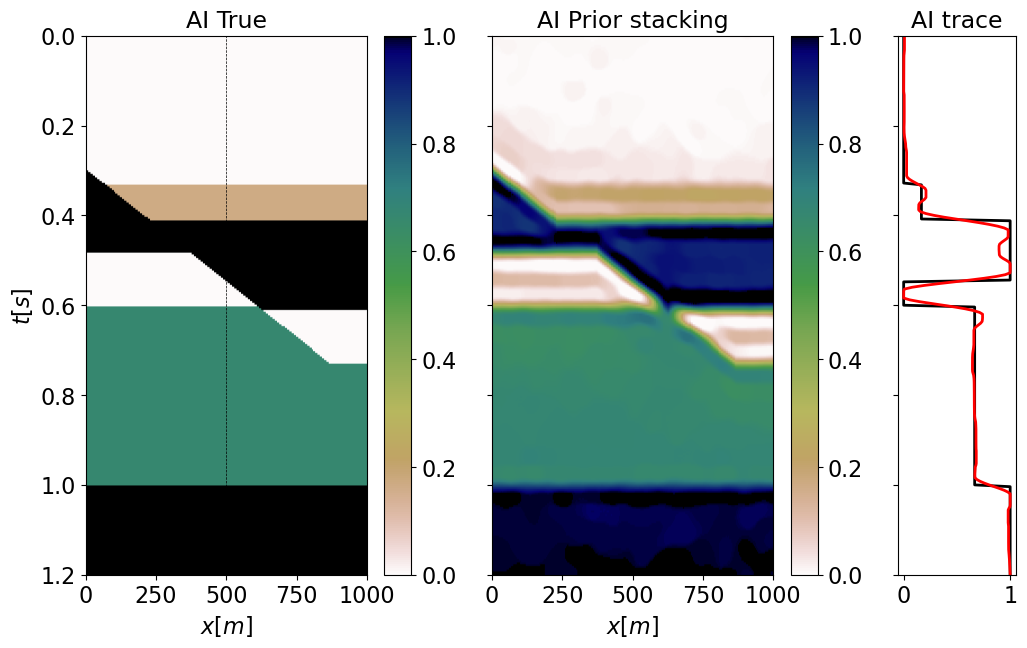

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(m, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(madmm1, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI Prior stacking', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(m[:, nx//2], t0, 'k', lw=2)
axs[2].plot(madmm1[:, nx//2], t0, 'r', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

## Primal Dual with Prior Stacking

In [14]:
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)

sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)

Dop = Gradient((nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
IOp = Identity((nt0, nx))
Kop = VStacklop([Dop, IOp])

box = Box(m.min(), m.max())
g = VStack([l1, box], nn=[2 * nt0 * nx, nt0 * nx])

L = 9. # np.real((Kop.H*Kop).eigs(neigs=1, which='LM')[0])
tau = 1
mu = 0.95 / (tau * L)

mpd = PrimalDual(l2, g, Kop, tau=tau, mu=mu, theta=1., 
                 x0=mback.ravel(), niter=100, gfirst=True, show=True)
mpd = mpd.reshape(nt0, nx) 

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 1.0		mu = 0.10555555555555556
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.71959e-04   7.012e+01   6.902e+00   0.000e+00       7.702e+01
     2   1.79745e-03   2.981e+01   8.260e+00   0.000e+00       3.807e+01
     3   3.07203e-03   1.528e+01   9.217e+00   0.000e+00       2.450e+01
     4   4.62913e-03   9.347e+00   9.730e+00   0.000e+00       1.908e+01
     5   6.29019e-03   6.547e+00   9.970e+00   0.000e+00       1.652e+01
     6   7.88637e-03   5.031e+00   1.008e+01   0.000e+00       1.511e+01
     7   9.30269e-03   4.113e+00   1.013e+01   0.000e+00       1.424e+01
     8   1.04860e-02   3.509e+0

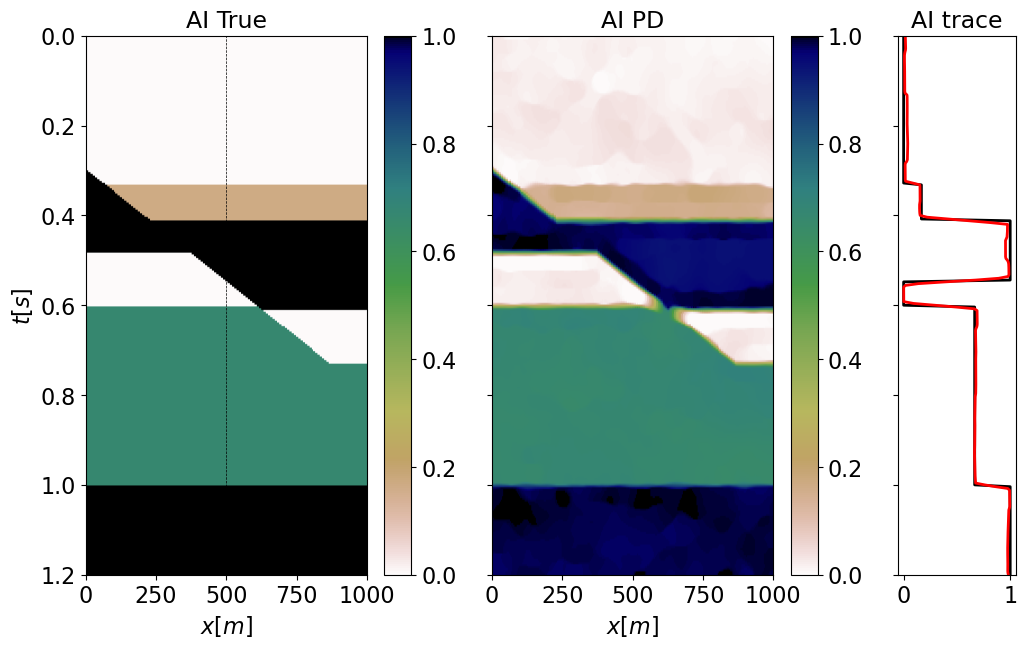

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(12, 7))
im = axs[0].imshow(m, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//2], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI True', fontsize=17)
im = axs[1].imshow(mpd, vmin=m.min(), vmax=m.max(),
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('AI PD', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(m[:, nx//2], t0, 'k', lw=2)
axs[2].plot(mpd[:, nx//2], t0, 'r', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17);

## Comparison

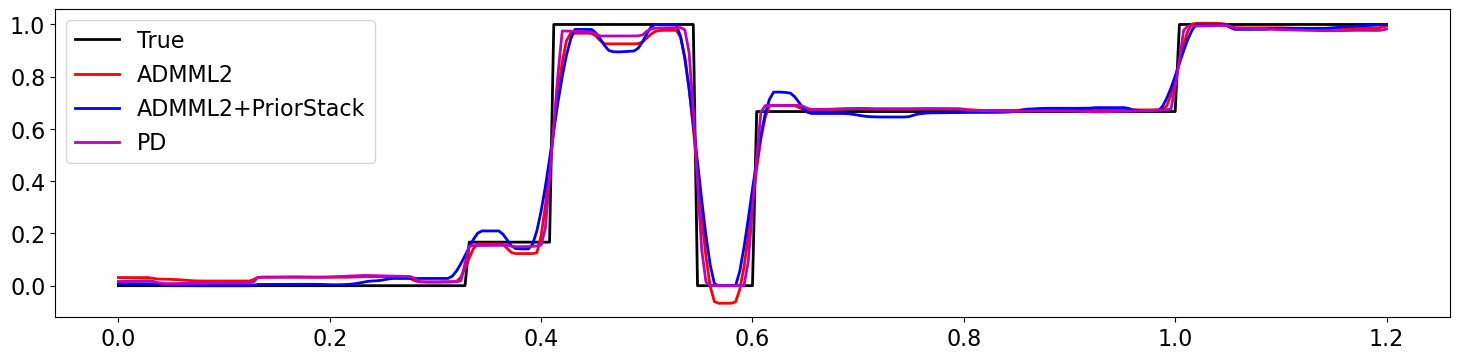

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
ax.plot(t0, m[:, nx//2], 'k', lw=2, label='True')
ax.plot(t0, madmm[:, nx//2], 'r', lw=2, label='ADMML2')
ax.plot(t0, madmm1[:, nx//2], 'b', lw=2, label='ADMML2+PriorStack')
ax.plot(t0, mpd[:, nx//2], 'm', lw=2, label='PD')
ax.legend();

In [18]:
snr(m, mreg), snr(m, mpg), snr(m, madmm), snr(m, madmm1), snr(m, mpd)

(np.float64(18.228497122984603),
 np.float64(18.131329050816614),
 np.float64(20.23799093528887),
 np.float64(18.841756081813777),
 np.float64(21.972848123816465))